Use any additional libraries you want, but if you don't explicitly code stuff that I have explicitly asked you to code, you will not get marks.

In [29]:
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

### Q1. Kernel k-means

Let's try and end our course on a happy note. The smiley dataset you see below is made up of many clusters of points. 

In [30]:

plt.rcParams["figure.figsize"] = (5,5)




def getFigure( sizex = 7, sizey = 7 ):
    fig = plt.figure( figsize = (sizex, sizey) )
    return fig

def plot2D( X, fig, color = 'r', marker = '+', size = 100, empty = False ):
    plt.figure( fig.number )
    if empty:
        plt.scatter( X[:,0], X[:,1], s = size, facecolors = 'none', edgecolors = color, marker = marker  )
    else:
        plt.scatter( X[:,0], X[:,1], s = size, c = color, marker = marker )


def genCrescentData( d, n, mu, r, flipped = False ):
    X = np.vstack( (np.cos( np.linspace( 0, np.pi, n ) ), np.sin( np.linspace( 0, np.pi, n ) ) ) ).T
    if flipped:
        X[:,1] = -np.abs( X[:,1] )
    else:
        X[:,1] = np.abs( X[:,1] )
    X = (X * r) + mu
    return X

def genSphericalData( d, n, mu, r ):
    np.random.seed(5)
    X = np.random.normal( 0, 1, (n, d) )
    norms = lin.norm( X, axis = 1 )
    X = X / norms[:, np.newaxis]
    X = (X * r) + mu
    return X

In [31]:
d = 2
n = 200

mu1 = np.array( [0,0] )
mu2 = np.array( [0,1] )
mu3 = np.array( [0,0] )
mu4 = np.array( [-3,5] )
mu5 = np.array( [3,5] )

tmp1 = genCrescentData( d, n, mu1, 1 )
tmp2 = genCrescentData( d, n, mu2, 5, flipped = True )
tmp3 = genSphericalData( d, n, mu3, 10 )
tmp4 = genSphericalData( d, n, mu4, 1 )
tmp5 = genSphericalData( d, n, mu5, 1 )
X = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5) )

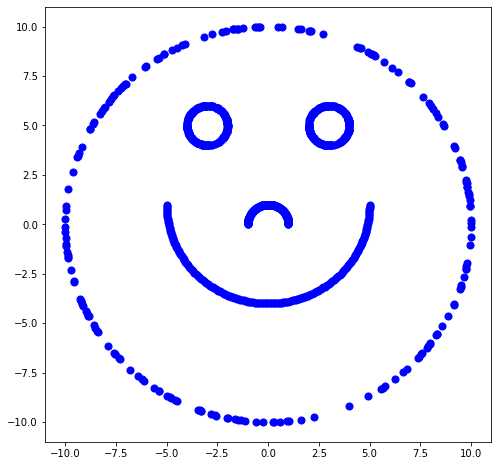

In [32]:
fig = getFigure( 8, 8 )
plot2D( X, fig, size = 50, color = 'b', marker = 'o' )

# (a) Can you implement the k-means algorithm to cluster this dataset? Visualize your output. [10 points] 




In [33]:
m=X.shape[0] #number of training examples
n=X.shape[1] #number of features
n_iter=1000 #maximum number of iterations for Kmeans in case the algo fails to converge

### Shape of the given dataset is as below

In [34]:
m,n

(1000, 2)


## K-Means Clustering 
1. Choose the number of clusters(K) and obtain the data points 
2. Place the centroids c_1, c_2, ..... c_k randomly 
3. Repeat steps 4 and 5 until convergence or until the end of a fixed number of iterations
4. for each data point x_i:
       - find the nearest centroid(c_1, c_2 .. c_k) 
       - assign the point to that cluster 
5. for each cluster j = 1..k
       - new centroid = mean of all points assigned to that cluster
6. End 

In [35]:
def kmeans(X,K):

    global n_iter
    np.random.seed(5) #using seed to generate consistent results
    centroids=np.array([]).reshape(n,0)
     # selecting random points from the dataset as centroids
    for i in range(K):
        idx=np.random.randint(0,m-1)
        centroids=np.c_[centroids,X[idx]]

    # initializing an array of cluster means which would be updated in each of the iteration
    C=np.zeros(m,)

    #Initializing the output dictionary which contains keys as cluster numbers and values as data points in that cluster
    Output = {}


    for i in range(n_iter):
        C_prev=C
        distance=np.array([]).reshape(m,0)
        for k in range(K):
            tempDist=np.sum((X-centroids[:,k])**2,axis=1)
            distance=np.c_[distance,tempDist]
        C=np.argmin(distance,axis=1)+1
        
        # stopping when we find that the current means are same as the previous means
        if(np.array_equal(C_prev,C,equal_nan=True)): 
            break
        
        
        Y={}

        for k in range(K):
            Y[k+1]=np.array([]).reshape(n,0)

        for i in range(m):
            Y[C[i]]=np.c_[Y[C[i]],X[i]]

        
        for k in range(K):
            Y[k+1]=Y[k+1].T

        
        for k in range(K):
            centroids[:,k]=np.mean(Y[k+1],axis=0)
        Output=Y

    return centroids, Output

### Below is the implementation of Kmeans algorithm for the cluster sizes in range, __[2,8]__, as we don't know the optimal cluster size yet

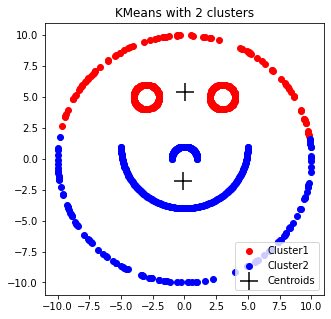

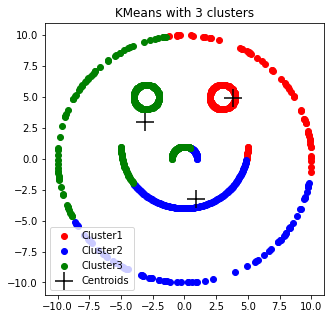

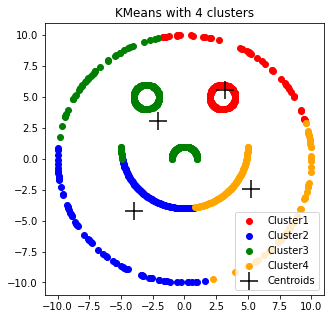

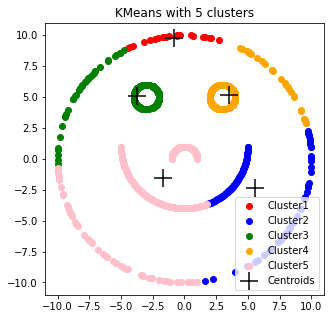

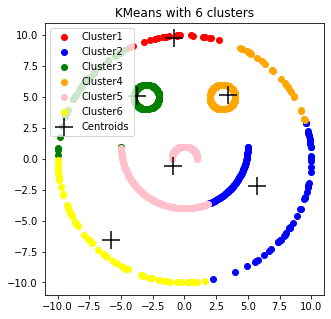

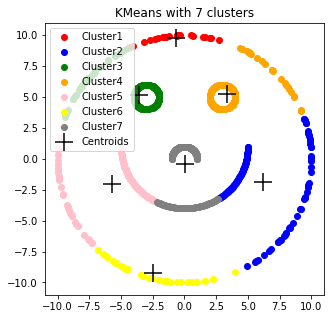

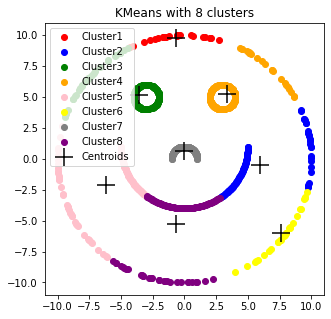

In [36]:
for cluster in range(2,9):
    Centroids,Output = kmeans(X,cluster)
    color=['red','blue','green','orange','pink','yellow','grey','purple']
    labels=['Cluster1','Cluster2','Cluster3','Cluster4','Cluster5','Cluster6','Cluster7','Cluster8']
    for k in range(cluster):
        plt.scatter(Output[k+1][:,0],Output[k+1][:,1],c=color[k],label=labels[k])
    plt.title("KMeans with {0} clusters".format(cluster))
    plt.scatter(Centroids[0,:],Centroids[1,:],s=300,c='black',label='Centroids', marker='+')
    
    plt.legend()
    plt.show()

> The centroids above are randomly generated which may seem a bit weary at times. Next you will see an implementation of KMeans++ which uses some smart rule based approach to decide the centroids, instead of just some random prediction

# (b) Implement k-means++ to initialize cluster centers usefully. [5 points]



In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


## Below is the "initialization" function, which initializes the centroids according the following set of steps:

1. Randomly select the first centroid from the data points.
2. For each data point compute its distance from the nearest, previously chosen centroid.
3. Select the next centroid from the data points such that the probability of choosing a point as centroid is directly proportional to its distance from the nearest, previously chosen centroid. (i.e. the point having maximum distance from the nearest centroid is most likely to be selected next as a centroid)
4. Repeat steps 2 and 3 until k centroids have been sampled

In [38]:
def distance(p1, p2): # gives Euclidean distance
    return np.sum((p1 - p2)**2)
  
# initialization algorithm
def initialize(data, k):
    '''
    initialized the centroids for K-means++
    inputs:
        data - numpy array of data points having shape (200, 2)
        k - number of clusters
    '''
    ## initialize the centroids list and add
    ## a randomly selected data point to the list
    centroids = []
    np.random.seed(5)
    centroids.append(data[np.random.randint(
            data.shape[0]), :])
    
  
    ## compute remaining k - 1 centroids
    for c_id in range(k - 1):
         
        ## initialize a list to store distances of data
        ## points from nearest centroid
        dist = []
        for i in range(data.shape[0]):
            point = data[i, :]
            d = sys.maxsize
             
            ## compute distance of 'point' from each of the previously
            ## selected centroid and store the minimum distance
            for j in range(len(centroids)):
                temp_dist = distance(point, centroids[j])
                d = min(d, temp_dist)
            dist.append(d)
             
        ## select data point with maximum distance as our next centroid
        dist = np.array(dist)
        next_centroid = data[np.argmax(dist), :]
        centroids.append(next_centroid)
        dist = []
        
    return centroids
  
# call the initialize function to get the centroids


### The function below is an implementation of KMeans++ algorithm, and is a slight modification of the classic KMeans as implemented above. The only change is, insted of chosing the Centroids randomly, we are generating them usefully using the Initialization function mentioned above, and using these calculated Centroids for further processing

In [39]:
def kmeansplusplus(X,K,centroids):

    global n_iter

    # initializing an array of cluster means which would be updated in each of the iteration
    C=np.zeros(m,)

    #Initializing the output dictionary which contains keys as cluster numbers and values as data points in that cluster
    Output = {}


    for i in range(n_iter):
        C_prev=C
        distance=np.array([]).reshape(m,0)
        for k in range(K):
            tempDist=np.sum((X-centroids[:,k])**2,axis=1)
            distance=np.c_[distance,tempDist]
        C=np.argmin(distance,axis=1)+1
        
        # stopping when we find that the current means are same as the previous means
        if(np.array_equal(C_prev,C,equal_nan=True)): 
            break
        
        
        Y={}

        for k in range(K):
            Y[k+1]=np.array([]).reshape(n,0)

        for i in range(m):
            Y[C[i]]=np.c_[Y[C[i]],X[i]]

        
        for k in range(K):
            Y[k+1]=Y[k+1].T

        
        for k in range(K):
            centroids[:,k]=np.mean(Y[k+1],axis=0)
        Output=Y

    return Output

### Below is the implementation of Kmeans++ algorithm for the cluster sizes in range, __[2,8]__, as we don't know the optimal cluster size yet

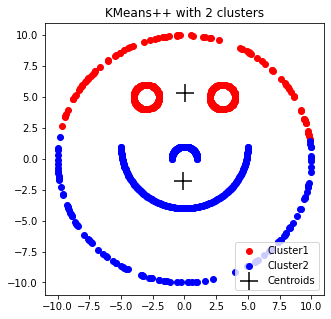

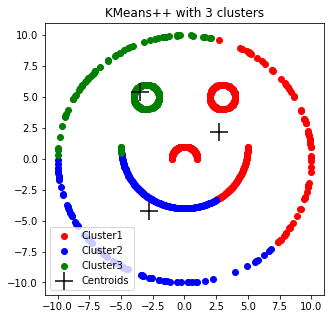

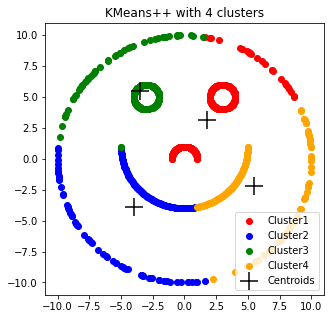

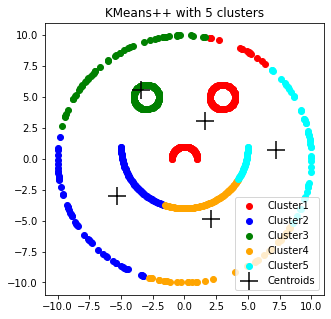

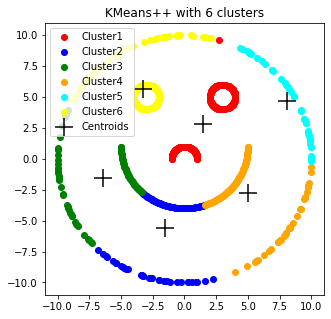

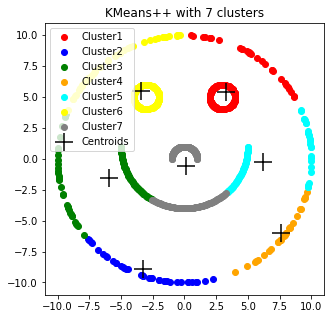

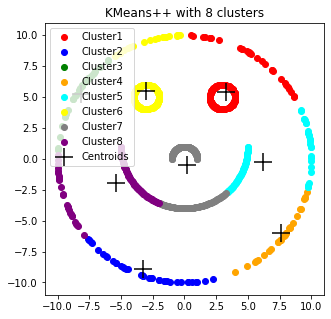

In [40]:
for cluster in range(2,9):
    Centroids = initialize(X, cluster)
    Centroids = np.array(Centroids).T
    
    Output = kmeansplusplus(X,cluster,Centroids)
    color=['red','blue','green','orange','cyan','yellow','grey','purple']
    labels=['Cluster1','Cluster2','Cluster3','Cluster4','Cluster5','Cluster6','Cluster7','Cluster8']
    for k in range(cluster):
        plt.scatter(Output[k+1][:,0],Output[k+1][:,1],c=color[k],label=labels[k])
    plt.title("KMeans++ with {0} clusters".format(cluster))
    plt.scatter(Centroids[0,:],Centroids[1,:],s=300,c='black',label='Centroids', marker='+')
    #plt.rcParams["figure.figsize"] = (5,5)
    plt.legend()
    plt.show()

# (c) What value of k gives you the best clustering? Are you happy with the quality of the clustering? [5 points]

### We will try to use the Elbow graph method for finding an optimal value of __K__
### Here WCSS stands for Within Cluster Sum of Squares. We are calculating wcss for every cluster size and then we will plot it to see the trend

Number of Clusters: 1 		WCSS: 35196.721261195264
Number of Clusters: 2 		WCSS: 22454.37816696336
Number of Clusters: 3 		WCSS: 16234.261813894802
Number of Clusters: 4 		WCSS: 11767.73549986045
Number of Clusters: 5 		WCSS: 10741.721962110714
Number of Clusters: 6 		WCSS: 7539.194799203813
Number of Clusters: 7 		WCSS: 5922.020727148423
Number of Clusters: 8 		WCSS: 5102.404437279334
Number of Clusters: 9 		WCSS: 4677.309839840816
Number of Clusters: 10 		WCSS: 3834.9257394655924
Number of Clusters: 11 		WCSS: 3000.4235208253144
Number of Clusters: 12 		WCSS: 2297.431680390375
Number of Clusters: 13 		WCSS: 2051.7118652183485
Number of Clusters: 14 		WCSS: 1962.794785996977
Number of Clusters: 15 		WCSS: 1885.1993308333808
Number of Clusters: 16 		WCSS: 1694.3702528085107
Number of Clusters: 17 		WCSS: 1501.6906011287726
Number of Clusters: 18 		WCSS: 1413.8675218252536
Number of Clusters: 19 		WCSS: 1332.3548830143434
Number of Clusters: 20 		WCSS: 1125.4244719750166
Number of Cluster

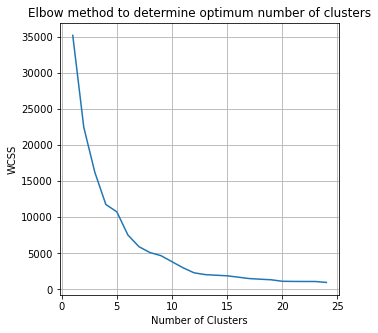

In [41]:
WCSS_array=np.array([])
for K in range(1,25):
    wcss=0
    Centroids,Output = kmeans(X, K)
    Centroids = Centroids.T
    #print(Centroids, Output)
    for k in range(K):
        wcss+=np.sum((Output[k+1]-Centroids[k,:])**2)
    WCSS_array=np.append(WCSS_array,wcss)
    print('Number of Clusters:', K,'\t\tWCSS:', wcss)

K_array=np.arange(1,25,1)
plt.plot(K_array,WCSS_array)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow method to determine optimum number of clusters')
plt.grid()
plt.show()

## The Elbow graph has given us the following inferences:
1. The cluster sizes __5, 9__ seem reasonable __Elbow tips__ and are reasonably decent choices
2. Based on the appearance of the dataset, I have chosen __5__ as the right choice, please find the implementation of __KMeans__ below

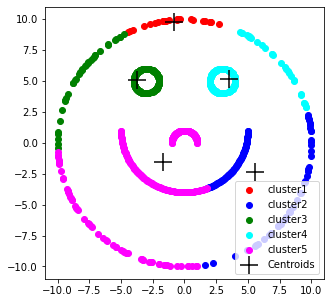

In [42]:
K=5
Centroids,Output = kmeans(X, K)

color=['red','blue','green','cyan','magenta']
labels=['cluster1','cluster2','cluster3','cluster4','cluster5']
for k in range(K):
    plt.scatter(Output[k+1][:,0],Output[k+1][:,1],c=color[k],label=labels[k])
#plt.scatter(Centroids[0],Centroids[1],s=300,label='Centroids', marker='+', color='black')
plt.scatter(Centroids[0,:],Centroids[1,:],s=300,c='black',label='Centroids', marker='+')
#plt.rcParams["figure.figsize"] = (5,5)
plt.legend()
plt.show()


### Using the same value of K=5, below is an implementaion of __KMeans++__

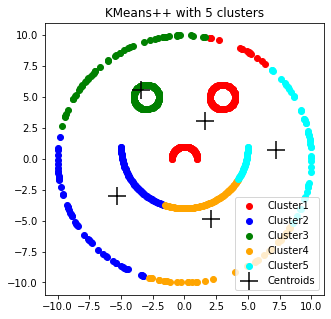

In [43]:
K=5
Centroids = initialize(X, K)
Centroids = np.array(Centroids).T

Output = kmeansplusplus(X,K,Centroids)
color=['red','blue','green','orange','cyan','yellow','grey','purple']
labels=['Cluster1','Cluster2','Cluster3','Cluster4','Cluster5','Cluster6','Cluster7','Cluster8']
for k in range(K):
    plt.scatter(Output[k+1][:,0],Output[k+1][:,1],c=color[k],label=labels[k])
plt.title("KMeans++ with {0} clusters".format(K))
plt.scatter(Centroids[0,:],Centroids[1,:],s=300,c='black',label='Centroids', marker='+')
#plt.rcParams["figure.figsize"] = (5,5)
plt.legend()
plt.show()

## Inference: 
1. If you carefully notice, the centroids as well as coloring in KMeans plus is better and organized. 
2. All the centroids are well inside the scatter plot, and seem to cover the entire dataset

# (d) I'm going to say that we want to be able to do better than this. So I want you to kernelize your k-means algorithm with a Gaussian kernel. Visualize the clustering output of your kernel k-means algorithm [15 points]

### Below is the function of a Gaussian Kernel and how we get our initial dataset kernelized
- Original dimensions: 1000*2
- New Dimensions: 1000*1000

In [44]:
def GaussianKernel(a,b):
    var = 4 #variance
    some = a-b
    val = (some[0]**2 + some[1]**2)/(2*var*2)
    result = np.exp(-val)
    return result

X_ = np.zeros(1000000).reshape(1000,1000)
for i in range(1000):
    for j in range(1000):
        d = GaussianKernel(X[i],X[j])
        X_[i][j] = d


In [45]:

def kmeansrbf(X, K):
    m=1000
    n=1000
   
    Centroids=np.array([]).reshape(m,0) 
    C_ind = []
   
    for i in range(K):
        rand = np.random.randint(0, m-1)
        C_ind.append(rand)
        #rand=rd.randint(0,1000-1)
        Centroids=np.c_[Centroids,X[rand]]
    C=np.zeros(m,)

    Output = {}
    for i in range(n_iter):
        #step 2.aC
        C_prev=C
        distance=np.array([]).reshape(m,0)
        for k in range(K):
            tempDist=np.sum((X-Centroids[:,k])**2,axis=1)
            distance=np.c_[distance,tempDist]
        C=np.argmin(distance,axis=1)+1
        if(np.array_equal(C_prev,C,equal_nan=True)):
            break
        Y={}
        Y_ind = {}
        for k in range(K):
            Y[k+1]=np.array([]).reshape(1000,0)
            Y_ind[k+1]=np.array([]).reshape(1,0)
        for i in range(m):
            Y[C[i]]=np.c_[Y[C[i]],X[i]]
            Y_ind[C[i]]=np.c_[Y_ind[C[i]],i]
        for k in range(K):
            Y[k+1]=Y[k+1].T
        
        for k in range(K):
            Centroids[:,k]=np.mean(Y[k+1],axis=0)
        Output=Y

    return Centroids, Y_ind, C_ind

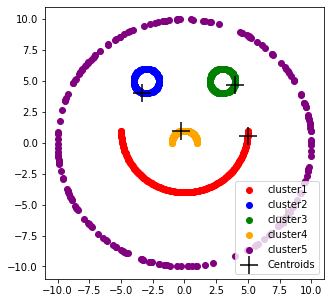

In [46]:
K=5
_,Y_ind, C_ind = kmeansrbf(X_, K)
color=['red','blue','green','orange','purple','cyan']
labels=['cluster1','cluster2','cluster3','cluster4','cluster5', 'cluster6']
for k in range(K):
    plt.scatter(X[list(map(int, Y_ind[k+1].tolist()[0])),0], \
        X[list(map(int, Y_ind[k+1].tolist()[0])),1],\
            c=color[k],\
                label=labels[k])
plt.scatter(X[C_ind, 0], \
    X[C_ind, 1],\
        s=300,c='black',label='Centroids', marker='+')
#plt.rcParams["figure.figsize"] = (5,5)
plt.legend()
plt.show()

## Q2. Expectation-Maximization

We saw how to use EM to learn parameters for Gaussian mixture models last week. Specifically, for a GMM described by the set of parameters $\{\pi_k, \mu_k, \Sigma_k \}_{k=1}^K$, we saw that the E-step boils down to figuring out the expected assignment of clusters based on a responsibility judgment proportional to $\pi_k~N(\mu_k, \Sigma_k)$, given curent parameter estimates, followed by using GDA MLE updates assuming the current expected assignment in the M-step to update parameter values.

# (a) Can you derive the E-step and M-step for an EM algorithm that would work for a Gaussian mixture model wherein the mixture weights $\pi_k$ are known, and the covariances are restricted to be spherical, i.e. $\Sigma_k = \sigma^2_k I$? [20 points]

Let  k gaussian kernal be $$\theta= \{\mu_1,\mu_2...,\mu_k,{\sigma_1}^2,...{\sigma_k}^2\}$$ 
The  Probabity density of spherical gaussian $N(\mu,{\sigma}^2I), x\epsilon{R^d}$ is given by
$$ P(x)={\frac{1}{{(2\pi)}^{\alpha/2}{{\sigma}^\alpha }}}{e^{\frac{||x_n-\mu_k||^2}{{2}{\sigma}^2}}}$$

Let $X=\{x_1,x_2...x_n\}$ are n i.i.d.

 and $z=\{z_1,z_2,...z_n\}$ are correspondng latent variables.
Let let likelihood of ith sample came frpm spherical gaussian k be $\pi_k$ and $ P(z_i=k|\theta)={\pi}_k$

we have mixture weights as $\{\pi_1,\pi_2....\pi_k\}$ and it is given that its fixed.


let
$\theta= \{\mu_1,\mu_2...,\mu_k,{\sigma_1}^2,...{\sigma_k}^2,\pi_1,\pi_2....\pi_k\}$, likelihood of observing a data point 
given 
$$ P(x_i|z_i=k,\mu_k,\sigma_k^2)= N(x_i|\mu_k,\sigma_k^2)$$
the probability of observing our data point is 

$$P(X,Z|\theta)=\prod_{n=1}^N P(x_n, z_n|\theta)
=\prod_{n=1}^N P( z_n|\theta)P(x_n|z_n,\theta)$$

Whichs is equal to
$$ \prod_{n=1}^N\prod_{k=1}^K \prod_{k=1}^K{\pi_k}^{Z_{nk}} {P(x_n|z_n=k,\theta)}^{Z_{nk}}$$

where $Z_{nk}$ is the responsibility that nth data point belongs to the cluster K and 
$Z_{n1}+Z_{n2}.....+Z_{nk}=1$
so thev above boils down to
$$=\prod_{n=1}^N  {{{\pi_k}^{Z_{nk}}}{P(x_n|z_n=k,\theta)}}^{Z_{nk}}$$
for simplification taking log above reduces to
$$\sum_{n=1}^N {\sum_{k=1}^K{ log {\pi_k}{P(x_n|z_n=k,\theta)}}^{Z_{nk}}}$$
$$=\sum_{n=1}^N {\sum_{k=1}^K{ {Z_{nk}}\{\log\pi_k +\log{P(x_n|z_n=k,\theta)}}}\}$$
$$= \sum_{n=1}^N {\sum_{k=1}^K{ {Z_{nk}}\{\log\pi_k +\log{{\frac{1}{{(2\pi)}^{\alpha/2}{{\sigma_k}^\alpha }}}{e^{\frac{||x_n-\mu_k||^2}{{2}{\sigma_k}^2}}}}}}$$


Now since we  dont know the responsibilty in the estimation step we estimate them.
we compute conditional posterior $P(Z|X, \theta)$.
since data points are iid, we compute separately for each n.

from  bayes theorem $$P(z_n=k|x_n,\theta) \propto P(z_n=k|\theta)P(x_n|z_n=k,\theta)= {\pi_k}{N(x_n|\hat{\mu_k},{\hat{\sigma_k}}^2})  \forall n,k$$

$$E[Z_{nk}^{t}]= \frac{{\pi_k}{N(x_n|\hat{\mu_k},\hat{\sigma_k}}}{{\sum_{k=1}^K{{\pi_k}{N(x_n|\hat{\mu_k},\hat{\sigma_k})}}}}, \forall n,k$$
Now we estimate $Z_{nk} \forall n,k$ . 
we have to update \theta, i.e $\mu_k,\sigma_k^2 \forall k $ to maximize the probability of observing all the data points.

therefore
$$\hat{\theta} = argmax \sum_{n=1}^N {\sum_{k=1}^K{ {Z_{nk}}\{\log\pi_k +\log{{\frac{1}{{(2\pi)}^{\alpha/2}{{\sigma_k}^\alpha }}}{e^{\frac{||x_n-\mu_k||^2}{{2}{\sigma_k}^2}}}}}}$$
Fo Maximize $\mu_k, \sigma_k$ we individually do derivative with respect to them. 
First let us do with respect to $\mu_k$

$$\frac{\partial{P(X, Z|\theta)}}{\partial{\mu_k}}= \sum_{n=1}^N {{Z_{nk}}{(x_n-\mu_k)}{\frac{1}{\sigma_k^2}}}$$
$$\therefore 0=\sum_{n=1}^N {{Z_{nk}}{(x_n-\mu_k)}{\frac{1}{\sigma_k^2}}}$$
$$\therefore {\mu_k}^= \frac{\sum_{n=1}^N {Z_{nk}}{x_n}}{ \sum_{n=1}^N {Z_{nk}}}$$

Now let us derivate for $\sigma_k$
$$\frac{\partial{P(X, Z|\theta)}}{\partial{\sigma_k}}=\sum_{n=1}^N {{Z_{nk}}{\frac{{||x_n-\mu_k||}^2}{{\sigma_k}^3}}}-\sum_{n=1}^N{{Z_{nk}}{\frac{d}{\sigma_k}}}$$
$$\therefore 0=\sum_{n=1}^N {{Z_{nk}}{\frac{{||x_n-\mu_k||}^2}{{\sigma_k}^3}}}-\sum_{n=1}^N{{Z_{nk}}{\frac{d}{\sigma_k}}}$$

simplyfying we get 
$$\sigma_k^2= \frac{\sum_{n=1}^N {{Z_{nk}}} {{(x_j-\mu_k)}{(x_j-\mu_k)}^T}}{{d}{\sum_{n=1}^N{Z_{nk}}} }$$

The E step is given by :
$$Z_{nk}^{(t+1)}=\frac{{{\pi_k}{N(x_n|{\mu_k}^{(t)},{\sigma_k}^{(2t)})}}}{\sum_{k=1}^K{{{\pi_k}{N(x_n|{\mu_k}^{(t)},{\sigma_k}^{(2t)})}}}}$$

The M step is givem by :
$$ {\mu_k}^{(t+1)}= \frac{\sum_{n=1}^N {Z_{nk}}^{(t+1)}{x_n}}{ \sum_{n=1}^N {Z_{nk}}}$$

$$ {\sigma_k}^{(t+1) }= \frac{{{\sum_{j=1}^N {{Z_{nk}}^{(t+1}} } {{(x_j-{\mu_k}^{(t+1)})}{(x_j-{\mu_k}^{(t+1)})}^T}}}{{d}{\sum_{j=1}^N{Z_{nk}}^{(t+1)}}} $$

$$\pi_k^{(t+1)} = \frac{\sum_{n=1}^N {Z_{nk}}^{(t+1)}}{N}$$
    


# (b) Implement this algorithm and show that it works on synthetic data with 3 clusters. If you are unable to derive the EM algorithm for part (a), implement the EM algorithm I showed in the class slides for the standard GMM (5 point penalty for taking this option) [15 points]. 

In [19]:
m1 = [1,1]                                                # consider a random mean and 
m2 = [7,7]   
m3 = [10,0]

cov1 = [[3, 0], [0, 3]]                                   # random spherical covariance values   
cov2 = [[2, 0], [0, 2]]
cov3 = [[4, 0], [0, 4]]

x = np.random.multivariate_normal(m1, cov1, size=(200,))  # Generating samples for each mean and covariance
y = np.random.multivariate_normal(m2, cov2, size=(200,))
z = np.random.multivariate_normal(m3, cov3, size=(200,))
d = np.concatenate((x, y, z), axis=0)

pi = 1/3

### Plotting the three distributions obtained above

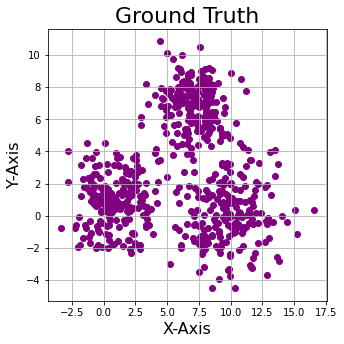

In [20]:
plt.figure(figsize=(5,5))                                 
plt.scatter(d[:,0], d[:,1], marker='o', color = 'purple')     
# plt.axis('equal')                                  
plt.xlabel('X-Axis', fontsize=16)              
plt.ylabel('Y-Axis', fontsize=16)                     
plt.title('Ground Truth', fontsize=22)    
plt.grid()            
plt.show()

In [21]:
# Taking initial guesses for the parameters

m1 = rnd.choice(len(d))
m1 = d[m1]
m2 = rnd.choice(len(d))
m2 = d[m2]
m3 = rnd.choice(len(d))
m3 = d[m3]

cov1 = [[8, 0], [0, 8]]  
cov2 = [[8, 0], [0, 5]] 
cov3 = [[5, 0], [0, 5]]

### Plotting the contours of initial guessed parameters and the three Normal Multivariate Distributions as well

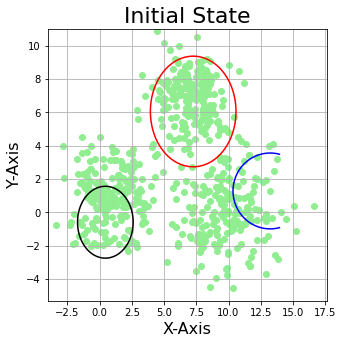

In [22]:
x1 = np.linspace(-4,14,200)  
x2 = np.linspace(-4,11,200)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(m1, cov1)  
Z2 = multivariate_normal(m2, cov2)
Z3 = multivariate_normal(m3, cov3)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(5,5))                                                          # creating the figure and assigning the size
plt.scatter(d[:,0], d[:,1], marker='o',color='#90ee90')     
plt.contour(X, Y, Z1.pdf(pos), levels=1, colors="r" ,alpha = 1) 
plt.contour(X, Y, Z2.pdf(pos), levels=1, colors="b" ,alpha = 1) 
plt.contour(X, Y, Z3.pdf(pos), levels=1, colors="black" ,alpha = 1) 
# plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('X-Axis', fontsize=16)                                                  # X-Axis
plt.ylabel('Y-Axis', fontsize=16)                                                  # Y-Axis
plt.title('Initial State', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()

In [23]:
# Expectation step

def Estep(paramlist):
    m1 = paramlist[0]
    m2 = paramlist[1]
    m3 = paramlist[2]
    
    cov1 = paramlist[3]
    cov2 = paramlist[4]
    cov3 = paramlist[5]
    
    pt1 = multivariate_normal.pdf(d, mean=m1, cov=cov1)
    pt2 = multivariate_normal.pdf(d, mean=m2, cov=cov2)
    pt3 = multivariate_normal.pdf(d, mean=m3, cov=cov3)
    
    w1 = pi * pt1
    w2 = pi * pt2
    w3 = pi * pt3
    eval1 = w1/(w1+w2+w3)
    eval2 = w2/(w1+w2+w3)
    eval3 = w3/(w1+w2+w3)
    evals = np.array([eval1, eval2, eval3])

    return(evals.T)

In [24]:
# Maximization step

def Mstep(evals):

    num_mu1,din_mu1, num_mu2,din_mu2, num_mu3,din_mu3 = 0,0,0,0,0,0
    for i in range(len(d)):

        num_mu1 += evals[i][0] * d[i]
        din_mu1 += evals[i][0]

        num_mu2 += evals[i][1] * d[i]
        din_mu2 += evals[i][1]
        
        num_mu3 += evals[i][2] * d[i]
        din_mu3 += evals[i][2]

    mu1 = num_mu1/din_mu1
    mu2 = num_mu2/din_mu2
    mu3 = num_mu3/din_mu3

    num_s1,din_s1, num_s2,din_s2, num_s3,din_s3 = 0,0,0,0,0,0    
    for i in range(len(d)):
        
        q1 = np.matrix(d[i]-mu1)
        num_s1 += evals[i][0] * np.dot(np.mean(np.diag(np.dot(q1.T, q1))), np.eye(2))
        din_s1 += evals[i][0]

        q2 = np.matrix(d[i]-mu2)
        num_s2 += evals[i][1] * np.dot(np.mean(np.diag(np.dot(q2.T, q2))), np.eye(2))
        din_s2 += evals[i][1]
        
        q3 = np.matrix(d[i]-mu3)
        num_s3 += evals[i][2] * np.dot(np.mean(np.diag(np.dot(q3.T, q3))), np.eye(2))
        din_s3 += evals[i][2]

    s1 = num_s1/din_s1
    s2 = num_s2/din_s2
    s3 = num_s3/din_s3
    
    lis2 = [mu1, mu2, mu3, s1, s2, s3]
    return(lis2)

In [25]:
def plot(paramlist, it): 
    
    x1 = np.linspace(-4,14,200)  
    x2 = np.linspace(-4,11,200)
    X, Y = np.meshgrid(x1,x2) 
    
    mu1 = paramlist[0]
    mu2 = paramlist[1]
    mu3 = paramlist[2]
    
    s1 = paramlist[3]
    s2 = paramlist[4]
    s3 = paramlist[5]
    
    Z1 = multivariate_normal(mu1, s1)  
    Z2 = multivariate_normal(mu2, s2)
    Z3 = multivariate_normal(mu3, s3)

    pos = np.empty(X.shape + (2,))                                                # a new array of given shape and type, without initializing entries
    pos[:, :, 0] = X; pos[:, :, 1] = Y   

    plt.figure(figsize=(5,5))                                                     # creating the figure and assigning the size
    plt.scatter(d[:,0], d[:,1], marker='o', color='#90ee90')     
    plt.contour(X, Y, Z1.pdf(pos), levels=1, colors="r" ,alpha = 1) 
    plt.contour(X, Y, Z2.pdf(pos), levels=1, colors="b" ,alpha = 1)
    plt.contour(X, Y, Z3.pdf(pos), levels=1, colors="black" ,alpha = 1)
    
    plt.title('Current iteration:{0}'.format(it+1))
    plt.xlabel('X-Axis', fontsize=16)                                             # X-Axis
    plt.ylabel('Y-Axis', fontsize=16)                                             # Y-Axis
    plt.grid()                                                                    # displaying gridlines
    plt.show()

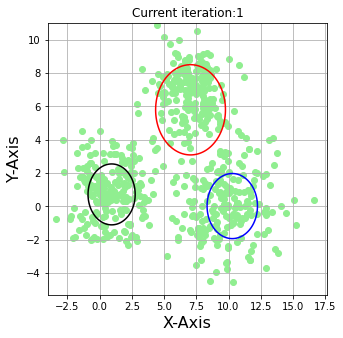

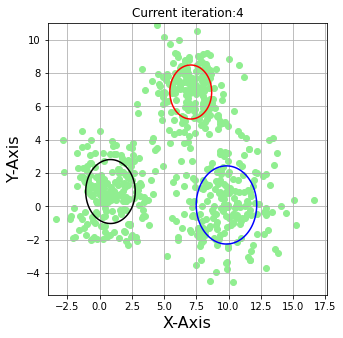

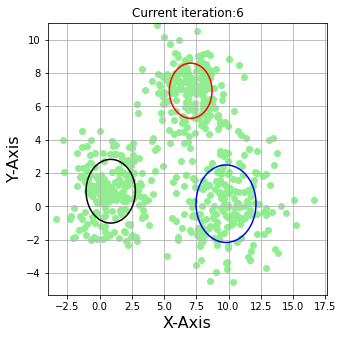

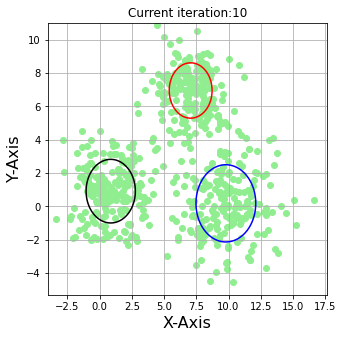

In [26]:
iterations = 10
lis1=[m1,m2,m3,cov1,cov2,cov3]
for i in range(0,iterations):
    lis2 = Mstep(Estep(lis1))
    lis1=lis2
    if(i==0 or i == 3 or i == 5 or i == 9):
        plot(lis1, i)

## Inference:
1. The contours become better and better with every passing iteration 


## END